In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os

# Make images appear inside the notebook instead of in a separate window
%matplotlib inline

# Import Data from Kaggle

In [ ]:
os.environ['KAGGLE_USERNAME'] = "username" # Replace with your actual Kaggle username
os.environ['KAGGLE_KEY'] = "inputket" # Replace with your actual Kaggle API key
import kaggle
kaggle.api.dataset_download_files('osamahosamabdellatif/high-quality-invoice-images-for-ocr', path='data', unzip=True)

## Function to display images in jupyter

In [9]:
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

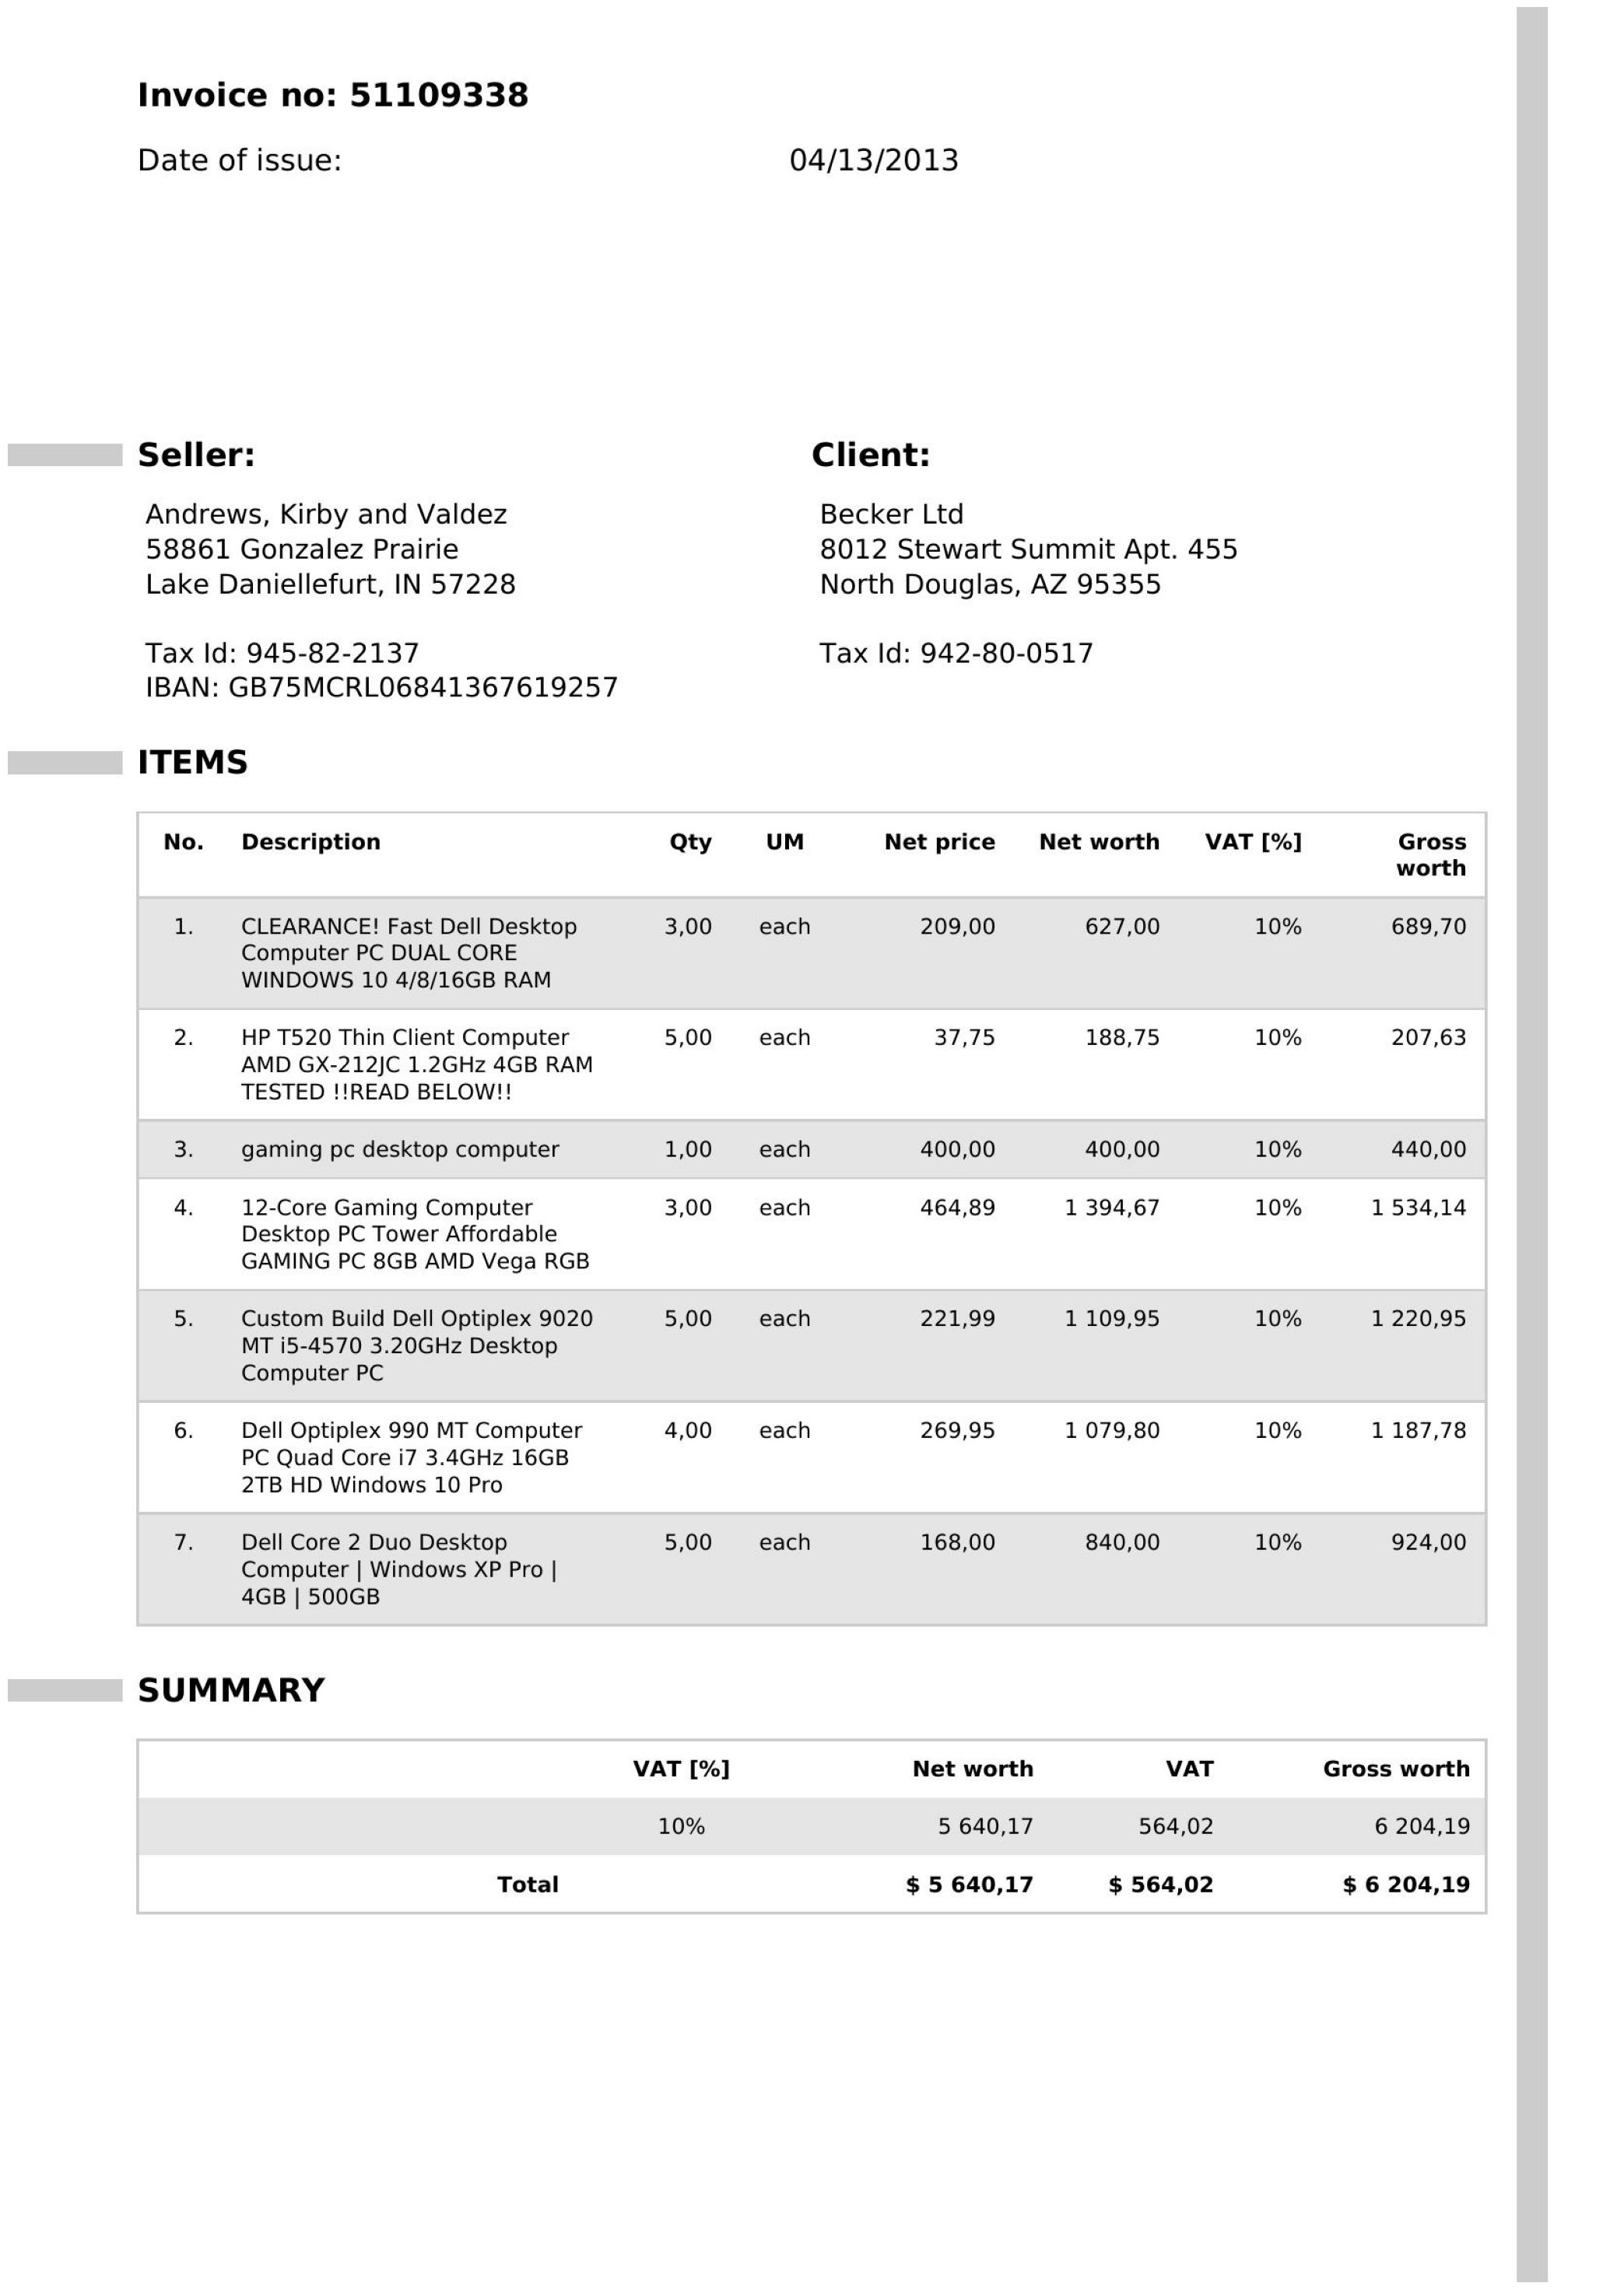

In [14]:
preview_img_path = os.path.join('data', 'batch_1', 'batch1_1','batch1-0001.jpg')
display(preview_img_path)